<a href="https://colab.research.google.com/github/doantronghieu/DEEP-LEARNING/blob/main/CSR_TF_Dev_Pro_Cert/C4/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, optimizers, metrics, models, Model,\
                             callbacks

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

def trend(time, slope = 0):
    return (slope * time)

def seasonal_pattern(season_time):
    """ Just an arbitrary pattern, you can change it if you wish """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """ Repeats the same pattern at each period """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time        = np.arange(4 * 365 + 1, dtype = "float32")
series      = trend(time, slope = 0.1)  
baseline    = 10
amplitude   = 40
slope       = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train    = series[:split_time]
x_valid    = series[split_time:]

window_size         = 20
batch_size          = 32
shuffle_buffer_size = 1000

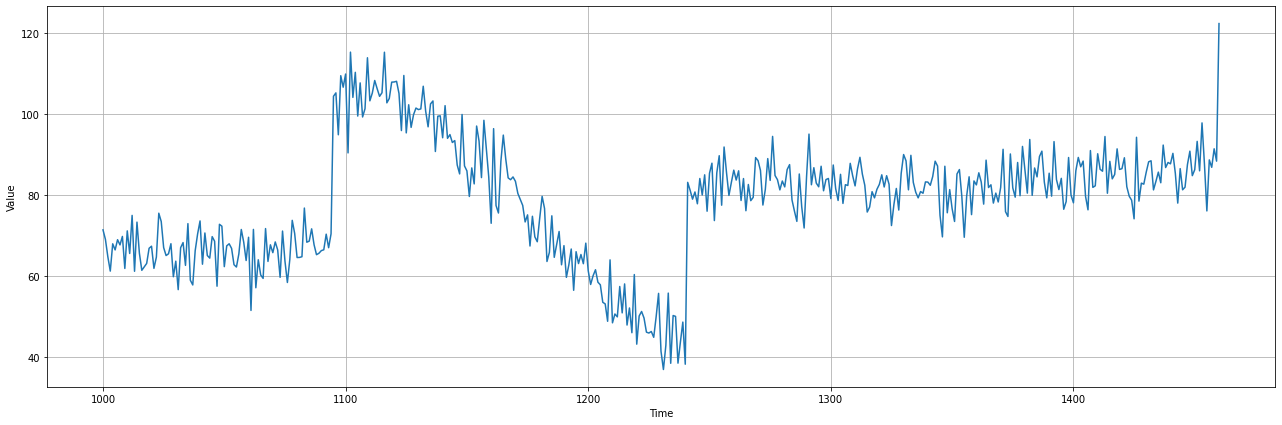

In [3]:
plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = models.Sequential([
    layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1)                           
])

model.compile(loss = losses.mse,
              optimizer = optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))

model.fit(dataset, epochs = 100, verbose = 0)

Error: 4.937178611755371


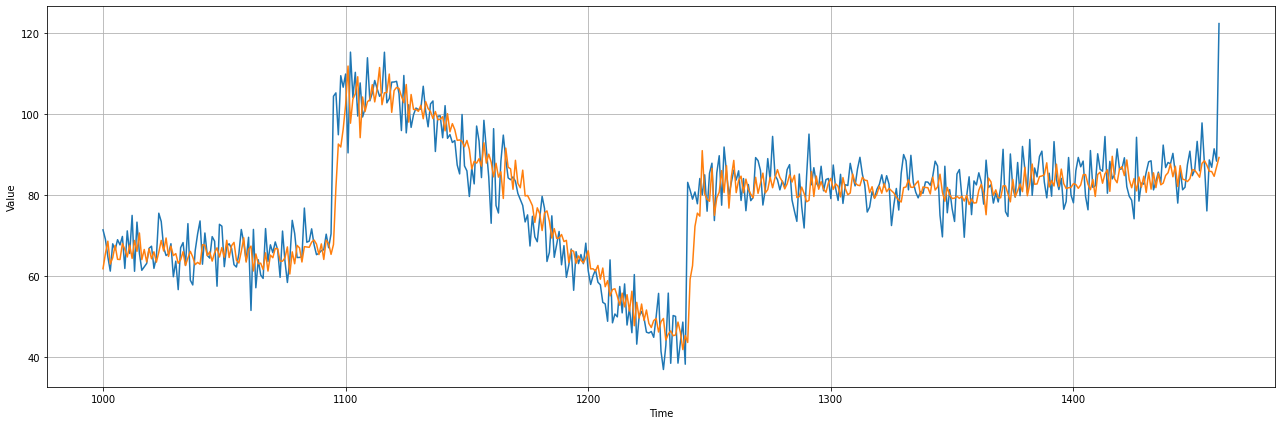

In [6]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(f'Error: {metrics.mean_absolute_error(x_valid, results).numpy()}')

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = models.Sequential([
    layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1)                           
])

lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

model.compile(loss = losses.mse,
              optimizer = optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))

history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule], verbose = 0)

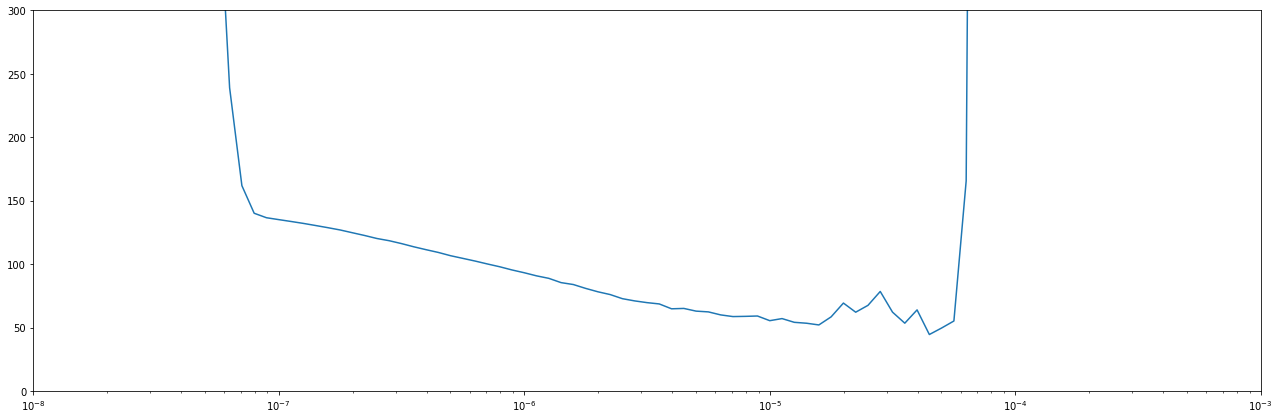

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize = (22, 7))
plt.semilogx(lrs, history.history['loss']);
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

In [13]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = models.Sequential([
    layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1)                           
])

model.compile(loss = losses.mse,
              optimizer = optimizers.SGD(learning_rate = 8e-6, momentum = 0.9))

model.fit(dataset, epochs = 500, verbose = 0)

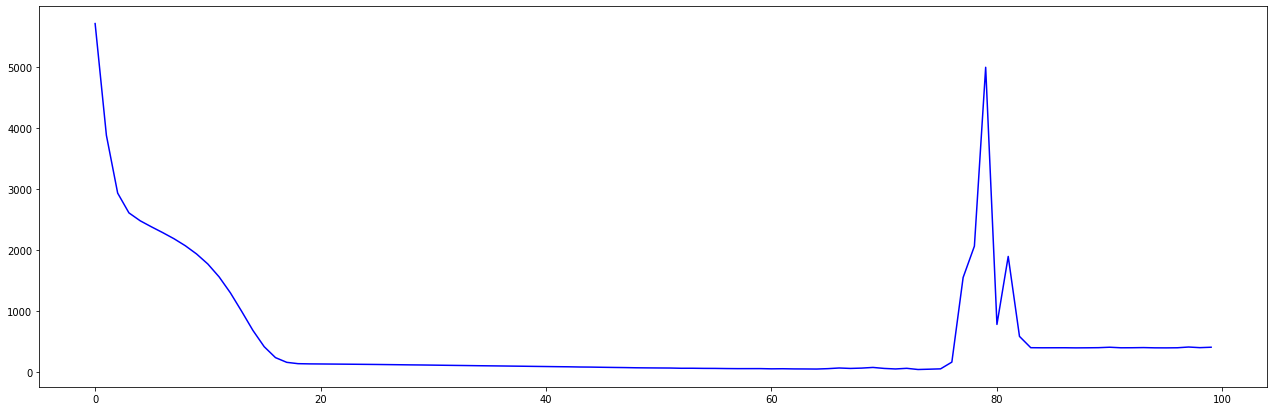

In [14]:
loss = history.history['loss']
epochs = range(len(loss))
plt.figure(figsize = (22, 7))
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

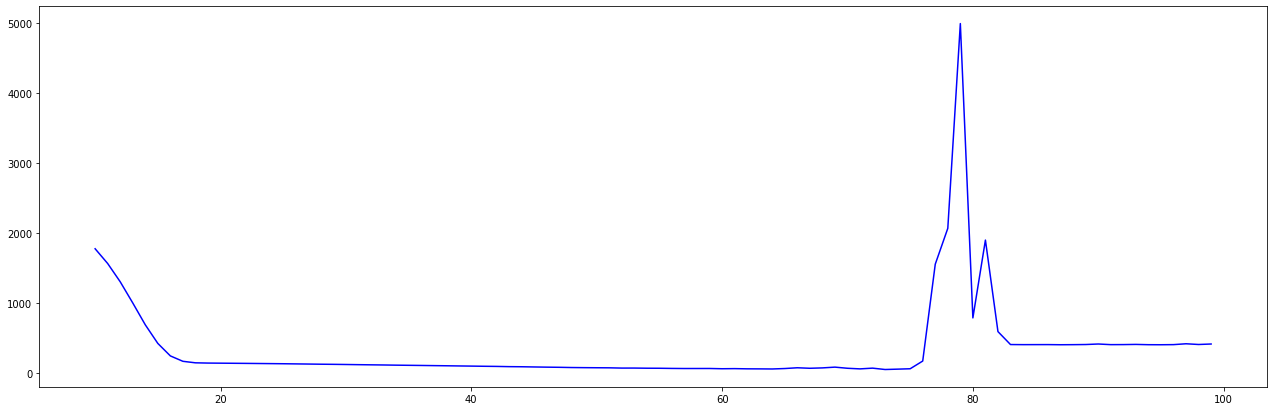

In [15]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.figure(figsize = (22, 7))
plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

Error: 4.907942771911621


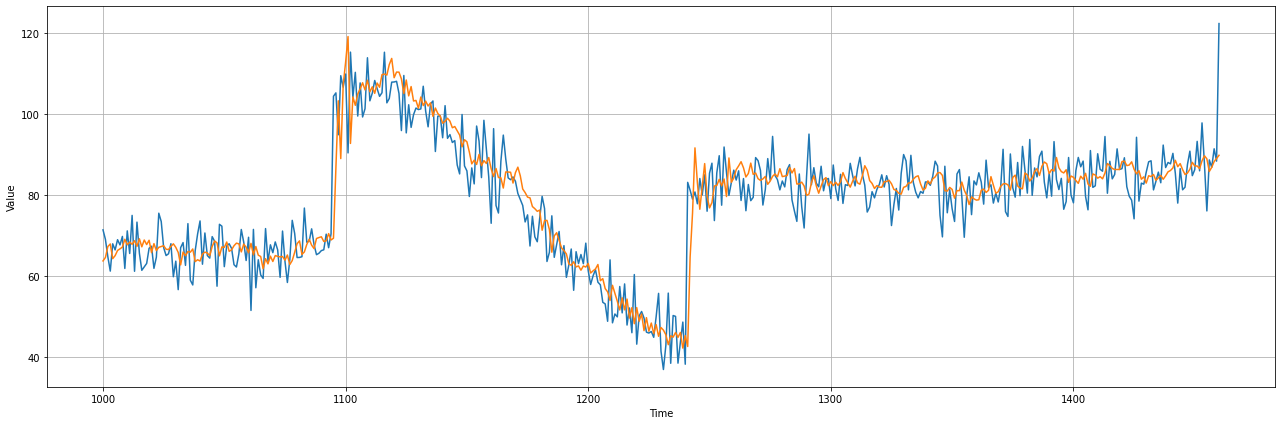

In [16]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(f'Error: {metrics.mean_absolute_error(x_valid, results).numpy()}')